# Mounting google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load modules

In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
%matplotlib inline

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Dense, Input, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2.0.0-alpha0


#  Load and explore data

In [0]:
# generate new csv file (run once)
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/text-classification/consumer_complaints.csv')   
df = df[pd.notnull(df['consumer_complaint_narrative'])]
df = df[['product', 'consumer_complaint_narrative']]
df = df.reset_index(drop=True)

In [0]:
df.head()

,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,Consumer Loan,Due to inconsistencies in the amount owed that...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,Mortgage,I have an open and current mortgage with Chase...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 2 columns):
product                         66806 non-null object
consumer_complaint_narrative    66806 non-null object
dtypes: object(2)
memory usage: 1.0+ MB


In [0]:
labels = df['product'].value_counts()
n_labels = len(labels)
print("Number of different products: ", n_labels)
print(labels)

Number of different products:  11
Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


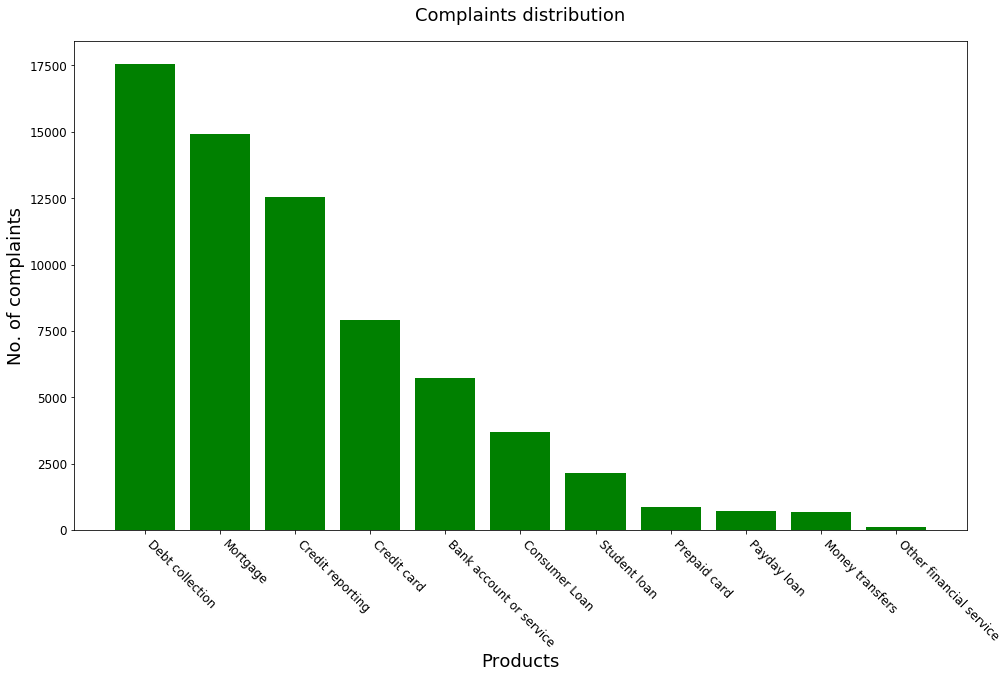

In [0]:
fig = plt.figure(figsize=(16, 9))
plt.bar(labels.index, labels, width=0.8, align='center', color='green')
plt.xlabel("Products", fontsize=18)
plt.ylabel("No. of complaints", fontsize=18)
plt.title("Complaints distribution", fontsize=18, pad=20)
plt.xticks(rotation=315, ha="left", fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [0]:
def print_text(index, df):
    sample = df[df.index == index].values[0]
    if len(sample) > 0:
        print('Product:', sample[0])
        print(sample[1])       
    else:
      print('Empty!')

In [0]:
print_text(0, df)
print_text(10, df)
print_text(20, df)

Product: Debt collection
XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! 
They continue to insist I owe them and collection agencies are after me. 
How can I stop this harassment for a bill I already paid four years ago? 

Product: Mortgage
I am very disappointed that the CFPB did not help to resolve this fraudulant loan. # XXXX between XXXX XXXX and XXXX, FF ( AKA ) One West. Case # XXXX with CFPB. 

Product: Credit reporting
I have been disputing incorrect information on my Experian XXXX XXXX XXXX credit report but they are unwilling to allow me to dispute their " investigation results ''. The creditors are XXXX XXXX and XXXX XXXX XXXX. The report reflects late payments and the information is inaccurate. XXXX creditors have agreed to have the items corrected on all XXXX credit bureaus but only XXXX made the correction. 



In [0]:
corpus_init = ' '.join(list(df['consumer_complaint_narrative']))
words_init = corpus_init.split()
n_words_init = len(words_init)
unique_words_init = sorted(list(set(words_init)))
n_unique_words_init = len(unique_words_init)
print("Total number of words before text preprocessing:", n_words_init)
print("Total number of unique words before text preprocessing: ", n_unique_words_init)
print(unique_words_init[:50])
print(unique_words_init[50:100])
print(unique_words_init[100:150])

Total number of words before text preprocessing: 12736164
Total number of unique words before text preprocessing:  132961
['!', '!!', '!!!!', '!!!)..........I', '!.', '"', '"!', '"!!', '",', '".', '"...', '"...a', '"???', '"ACCOUNT', '"Account', '"Alt-A"', '"Answer"', '"At', '"BAIT', '"CONTACT', '"CURRENT', '"Consumer', '"Do', '"Dual', '"ENHANCRCVRCO"', '"Everyday', '"Fresh', '"Good', '"Hold', '"How', '"I', '"If...the', '"In', '"Incomplete"', '"Investor"', '"Investor",', '"Investor".', '"Is', '"It', '"Know', '"MRS', '"No.Never.', '"Okay,', '"Pay', '"Previous', '"Re-entry"', '"Release', '"Right', '"She', '"Single']
['"The', '"Unknown"', '"Well,', '"XXXX', '"XXXX"', '"You', '"You\'ll', '"Your', '"account"', '"agree', '"anticipate', '"any', '"are', '"attorney"payments', '"bad', '"bed', '"bounce"', '"canceled",', '"charged', '"coding"', '"complicated', '"core"-', '"courtesy', '"credit', '"credited"', '"cushion"', '"dedicated', '"drive-by"', '"duplicate."', '"dwelling"!', '"exceptions"', '"

# Data Preparation

## Text preprocessing

In [0]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [0]:
stop_words = stopwords.words('english')

def text_prepocessing(text):
  # noise removal  
  text = re.sub(r'[xX]', '', text) # remove 'x'
  
  # normalization
  text = text.lower() # convert to lowercase text
  text = re.sub(r'\-',' ', text) # seperate words like 'video-related'
  text = re.sub(r'[-+]?\d*\.?\d+', ' NUMBER ', text) # replace numbers with "NUMBER"
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation  
  
  text = ' '.join(word for word in text.split() if word not in stop_words) # remove stop words
  text = ' '.join(lemmatize_verbs(text.split())) # Lemmatization
  
  return text

In [0]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(text_prepocessing)

In [0]:
print_text(0,df)
print_text(10,df)
print_text(20, df)

Product: Debt collection
claim owe NUMBER years despite proof payment send cancel check ownpaid invoice NUMBER continue insist owe collection agencies stop harassment bill already pay four years ago
Product: Mortgage
disappoint cfpb help resolve fraudulant loan ff aka one west case cfpb
Product: Credit reporting
dispute incorrect information eperian credit report unwilling allow dispute investigation result creditors report reflect late payments information inaccurate creditors agree items correct credit bureaus make correction


In [0]:
text_list = list(df['consumer_complaint_narrative'])
corpus = ' '.join(text_list)
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)
print(unique_words[:50])
print(unique_words[50:100])
print(unique_words[100:150])

Total number of words: 5721264
Total number of unique words:  50942
['NUMBER', 'aa', 'aaa', 'aaaked', 'aaarm', 'aac', 'aacceptance', 'aaccount', 'aaccounts', 'aacount', 'aadhar', 'aadvantage', 'aafes', 'aafraid', 'aag', 'aagain', 'aagainst', 'aagon', 'aaii', 'aaliant', 'aallc', 'aallcdelete', 'aalthough', 'aamerican', 'aand', 'aapproved', 'aarea', 'aargon', 'aaround', 'aarp', 'aas', 'aasigned', 'aasked', 'aasking', 'aastra', 'aat', 'aattempting', 'ab', 'aba', 'aback', 'abalance', 'aballished', 'abanding', 'abandment', 'abandoment', 'abandon', 'abandonded', 'abandoneddistressed', 'abandonedempty', 'abandonment']
['abank', 'abankruptcy', 'abarouting', 'abate', 'abatement', 'abatements', 'abbott', 'abbreviate', 'abbreviation', 'abbreviations', 'abbreviationssource', 'abc', 'abcd', 'abd', 'abdication', 'abduction', 'abel', 'aberrant', 'abet', 'abeyance', 'abhorrent', 'abide', 'abie', 'abilility', 'abilities', 'ability', 'abilitythe', 'abilityto', 'abill', 'abillionaire', 'abit', 'abject', 

## Parameters configuration

In [0]:
MAX_SEQUENCE_LENGTH = 250
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 20

## Load pre-trained word vectors

In [0]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/My Drive/Colab Notebooks/text-classification/glove.6B.100d.txt')) as f:
  # is a space-separated text file in the format: word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


## Tokenization, padding

In [0]:
# Prepare text and the labels
X = df['consumer_complaint_narrative'].values
y = pd.get_dummies(df['product']).values

In [0]:
# Convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=False)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [0]:
print("max sequence length:", max(len(s) for s in X))
print("min sequence length:", min(len(s) for s in X))
s = sorted(len(s) for s in X)
print("median sequence length:", s[len(s) // 2])

max sequence length: 402
min sequence length: 0
median sequence length: 61


In [0]:
# Get word to integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 50942 unique tokens.


In [0]:
# Pad sequences to get a fixed length for each sequence
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X:', X.shape)

Shape of X: (66806, 250)


In [0]:
# Create training set and test set
def shuffle_train_test_split(X_all, y_all, shuffle=True, test_percent=20, random_state=10):
    
    if shuffle:
      X_all_shuffled = []
      y_all_shuffled = []
      #for i in np.random.permutation(len(X_all)):
      for i in np.random.RandomState(seed=random_state).permutation(len(X_all)):
          X_all_shuffled.append(X_all[i])
          y_all_shuffled.append(y_all[i])
    else:
      X_all_shuffled = X_all
      y_all_shuffled = y_all

    split_index = int(len(X_all) * (1.-(test_percent/100.)))
    X_train, X_test = X_all_shuffled[:split_index], X_all_shuffled[split_index:]
    y_train, y_test = y_all_shuffled[:split_index], y_all_shuffled[split_index:]

    X_train = np.array(X_train)    
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = shuffle_train_test_split(X, y, test_percent=20)

print("Shape of X training set: ", X_train.shape)
print("Shape of y training set: ", y_train.shape)
print("Shape of X test set: ", X_test.shape)
print("Shape of y test set: ", y_test.shape)

Shape of X training set:  (53444, 250)
Shape of y training set:  (53444, 11)
Shape of X test set:  (13362, 250)
Shape of y test set:  (13362, 11)


## Prepare embedding layer

In [0]:
# Prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [0]:
# load pre-trained word embeddings into an embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False # set trainable = False to keep the embeddings fixed
)

# Modeling

## Build the model

In [0]:
# Create an LSTM network 
ip = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(ip)
x = LSTM(128,name='lstm_layer1',return_sequences = True)(x) 
x = Dropout(0.25)(x)
x = LSTM(128,name='lstm_layer2',return_sequences = True)(x)
x = Dropout(0.25)(x)
x = LSTM(128,name='lstm_layer')(x) # the last LSTM layer
x = Dropout(0.25)(x)
op = Dense(n_labels, activation="softmax")(x)

In [0]:
classifier = Model(inputs = ip, outputs = op)
classifier.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 100)          2000000   
_________________________________________________________________
lstm_layer1 (UnifiedLSTM)    (None, 250, 128)          117248    
_________________________________________________________________
dropout (Dropout)            (None, 250, 128)          0         
_________________________________________________________________
lstm_layer2 (UnifiedLSTM)    (None, 250, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
lstm_layer (UnifiedLSTM)     (None, 128)               131584

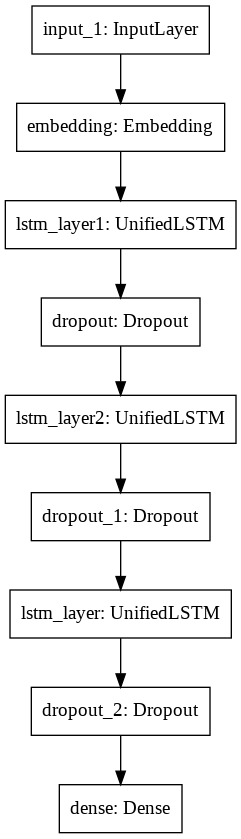

In [0]:
print(classifier.summary())
plot_model(classifier) # to_file='file_name.png'

## Train the model

In [0]:
model = classifier.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Train on 42755 samples, validate on 10689 samples
Epoch 1/20
42755/42755 [==============================] - 105s 2ms/sample - loss: 1.6871 - accuracy: 0.4057 - val_loss: 1.5844 - val_accuracy: 0.4770
Epoch 2/20
42755/42755 [==============================] - 102s 2ms/sample - loss: 1.6102 - accuracy: 0.4583 - val_loss: 1.6617 - val_accuracy: 0.4646
Epoch 3/20
42755/42755 [==============================] - 102s 2ms/sample - loss: 1.4563 - accuracy: 0.5244 - val_loss: 1.3091 - val_accuracy: 0.5783
Epoch 4/20
42755/42755 [==============================] - 103s 2ms/sample - loss: 1.3309 - accuracy: 0.5696 - val_loss: 1.2308 - val_accuracy: 0.5997
Epoch 5/20
42755/42755 [==============================] - 102s 2ms/sample - loss: 1.1746 - accuracy: 0.6214 - val_loss: 1.0973 - val_accuracy: 0.6379
Epoch 6/20
42755/42755 [==============================] - 102s 2ms/sample - loss: 1.0590 - accuracy: 0.6567 - val_loss: 1.0358 - val_accuracy: 0.6695
Epoch 7/20
42755/42755 [==========================

## Evaluation

In [0]:
test_evaluation = classifier.evaluate(X_test, y_test, batch_size = BATCH_SIZE)
print('Test set Loss: {:0.3f}\nTest set Accuracy: {:0.3f}'.format(test_evaluation[0],test_evaluation[1]))

13362/13362 [==============================] - 10s 741us/sample - loss: 0.6324 - accuracy: 0.8019
Test set Loss: 0.632
Test set Accuracy: 0.802


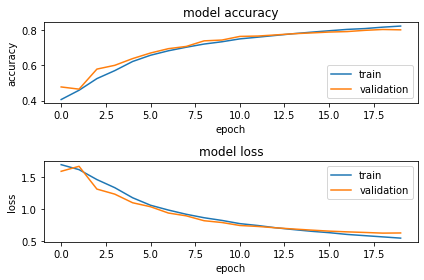

In [0]:
# Plot train and validation curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()


In [0]:
# Mean AUC over each label
y_predict = classifier.predict(X)
auc = roc_auc_score(y, y_predict)
aucs = []
for j in range(n_labels):
    auc = roc_auc_score(y[:,j], y_predict[:,j])
    aucs.append(auc)
print("Mean AUC over each label: {:0.3f} ".format(np.mean(aucs)))

Mean AUC over each label: 0.962 
